# Content-Aware Image Retargeting
Reduce the width of images (`Baby.png`, `Diana.png`, `Snowman.png`) by `seams_number` columns using Seam Carving, implemented from scratch. Optionally use depth/saliency maps or other energy functions. Visualize seams if enabled.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import io

In [2]:
def Energy_Map(image , DMap = None , SMap = None , energy_type = "gradient" , alpha = 0.5 , beta = 0.5): 
    gray = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
    if energy_type == "gradient":
        sobelX = cv2.Sobel(gray , cv2.CV_64F , 1 , 0 , ksize=3)
        sobelY = cv2.Sobel(gray , cv2.CV_64F , 0 , 1 , ksize=3)
        energy = np.sqrt(sobelX**2 + sobelY**2)
        
    elif energy_type == 'saliency' and SMap is not None:
        energy = SMap.copy()
        
    elif energy_type == 'depth' and DMap is not None:
        energy = DMap.copy()
        
    elif energy_type == 'combined':
        sobelX = cv2.Sobel(gray , cv2.CV_64F , 1 , 0 , ksize=3)
        sobelY = cv2.Sobel(gray , cv2.CV_64F , 0 , 1 , ksize=3)
        gradient = np.sqrt(sobelX**2 + sobelY**2)
        
        energy = alpha * gradient
        
        if SMap is not None:
            energy += beta * SMap
        if DMap is not None:
            energy += beta * DMap
                
    else:
        raise ValueError("value is not true!")
    
    return energy        

In [3]:
def vertical_finding(Emap):
    row, col = Emap.shape
    mapp = Emap.copy()
    
    backTracking = np.zeros_like(mapp, dtype=np.int32)
    for i in range(row - 2, -1, -1):
        for j in range(col):
            if j == 0: 
                min_idx = np.argmin(mapp[i+1, j:j+2])
                backTracking[i, j] = min_idx
                mapp[i, j] += mapp[i+1, j+min_idx]
            elif j == col - 1: 
                min_idx = np.argmin(mapp[i+1, j-1:j+1])
                backTracking[i, j] = min_idx - 1
                mapp[i, j] += mapp[i+1, j+min_idx-1]
            else: 
                min_idx = np.argmin(mapp[i+1, j-1:j+2])
                backTracking[i, j] = min_idx - 1
                mapp[i, j] += mapp[i+1, j+min_idx-1]
            
    j = np.argmin(mapp[0])
    seam_energy = mapp[0, j]
    
    seam = []
    
    for i in range(row):
        seam.append((i, j))
        if i < row-1:
            direction = backTracking[i, j]
            j += direction
    
    return seam, seam_energy

In [ ]:
def seam_carving(image, seams_number, depth_map=None, saliency_map=None, visualize=False, energy_type="gradient"):
    """Perform Seam Carving to reduce image width by seams_number columns."""
    # TODO: Implement Seam Carving from scratch
    seam_energies = []
    img_processed = image.copy()
    
    if visualize:
        img_visualization = image.copy()
        height, width, _ = image.shape
        
        output_video_viz_path = 'seam_visualization_video.avi'
        fps = 15
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        video_writer_viz = cv2.VideoWriter(output_video_viz_path, fourcc, fps, (width, height))
        
        output_video_shrink_path = 'seam_shrinking_video.avi'
        video_writer_shrink = cv2.VideoWriter(output_video_shrink_path, fourcc, fps, (width, height))


    # 4. Repeat for seams_number iterations
    for k in range(seams_number):
        print(f'Processing seam {k + 1}/{seams_number}...')
        
        # 1. Compute energy map (e.g., gradient, depth, or saliency-based)
        energy_map = Energy_Map(img_processed, depth_map, saliency_map, energy_type=energy_type)

        # 2. Find lowest-energy vertical seam using dynamic programming
        seam, seam_energy = vertical_finding(energy_map)
        
        # 6. Log seam energies
        seam_energies.append(seam_energy)

        # 5. Visualize seams if flag is enabled
        if visualize:
            for i, j in seam:
                img_visualization[i, j] = [0, 0, 1.0] # Red
            
            fig = plt.figure(figsize=(width/100, height/100), dpi=100)
            ax = fig.add_subplot(111)
            ax.imshow(cv2.cvtColor(img_visualization, cv2.COLOR_BGR2RGB))
            ax.set_title(f'Seam {k + 1}')
            ax.axis('off')
            
            buf = io.BytesIO()
            fig.savefig(buf, format='png')
            buf.seek(0)
            img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
            frame_bgr_viz = cv2.imdecode(img_arr, 1)
            buf.close()
            plt.close(fig)
            video_writer_viz.write(frame_bgr_viz)

        # 3. Remove seam and update image
        rows, cols, _ = img_processed.shape
        new_img = np.zeros((rows, cols - 1, 3), dtype=np.float32)
        
        for i in range(rows):
            j = seam[i][1]
            new_img[i, :, :] = np.delete(img_processed[i], j, axis=0)
        
        img_processed = new_img
        
        if visualize:
            frame_to_write = (img_processed * 255).astype(np.uint8)
            padding_needed = width - frame_to_write.shape[1]
            padded_frame = cv2.copyMakeBorder(frame_to_write, 0, 0, 0, padding_needed, cv2.BORDER_CONSTANT, value=[0,0,0])
            video_writer_shrink.write(padded_frame)

        if depth_map is not None:
            new_depth_map = np.zeros((rows, cols - 1), dtype=np.float32)
            for i in range(rows):
                j = seam[i][1]
                new_depth_map[i, :] = np.delete(depth_map[i], j, axis=0)
            depth_map = new_depth_map
        if saliency_map is not None:
            new_saliency_map = np.zeros((rows, cols - 1), dtype=np.float32)
            for i in range(rows):
                j = seam[i][1]
                new_saliency_map[i, :] = np.delete(saliency_map[i], j, axis=0)
            saliency_map = new_saliency_map

    if visualize:
        video_writer_viz.release()
        video_writer_shrink.release()
        print(f"Videos successfully saved at {output_video_viz_path} and {output_video_shrink_path}")

    return img_processed, seam_energies

In [5]:
# Load images and maps
baby_path = './Baby.png'
baby_dmap_path = './Baby_DMap.png'
baby_smap_path = './Baby_SMap.png'

baby = cv2.imread(baby_path).astype(np.float32) / 255.0
baby_dmap = cv2.imread(baby_dmap_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
baby_smap = cv2.imread(baby_smap_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0

# Parameters
seams_number = 200
visualize = True

Processing seam 1/200...
Processing seam 2/200...
Processing seam 3/200...
Processing seam 4/200...
Processing seam 5/200...
Processing seam 6/200...
Processing seam 7/200...
Processing seam 8/200...
Processing seam 9/200...
Processing seam 10/200...
Processing seam 11/200...
Processing seam 12/200...
Processing seam 13/200...
Processing seam 14/200...
Processing seam 15/200...
Processing seam 16/200...
Processing seam 17/200...
Processing seam 18/200...
Processing seam 19/200...
Processing seam 20/200...
Processing seam 21/200...
Processing seam 22/200...
Processing seam 23/200...
Processing seam 24/200...
Processing seam 25/200...
Processing seam 26/200...
Processing seam 27/200...
Processing seam 28/200...
Processing seam 29/200...
Processing seam 30/200...
Processing seam 31/200...
Processing seam 32/200...
Processing seam 33/200...
Processing seam 34/200...
Processing seam 35/200...
Processing seam 36/200...
Processing seam 37/200...
Processing seam 38/200...
Processing seam 39/20

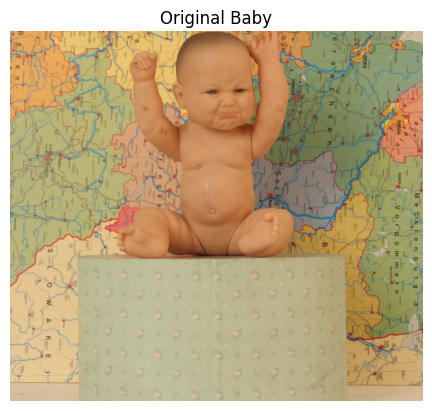

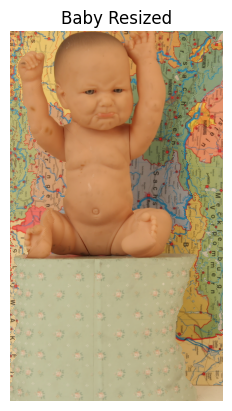

True

In [6]:
# Process images
baby_resized, baby_energies = seam_carving(baby, seams_number, baby_dmap, baby_smap, visualize, energy_type='combined')

# Save seam energies
with open('seam_energy_log.txt', 'w') as f:
    f.write('Baby Seam Energies:\n' + '\n'.join(map(str, baby_energies)) + '\n')

# Visualize results
plt.imshow(cv2.cvtColor(baby, cv2.COLOR_BGR2RGB))
plt.title('Original Baby')
plt.axis('off')
plt.show()
plt.imshow(cv2.cvtColor(baby_resized, cv2.COLOR_BGR2RGB))
plt.title('Baby Resized')
plt.axis('off')
plt.show()

# Save resized images
cv2.imwrite('Baby_resized.png', (baby_resized * 255).astype(np.uint8))

In [7]:
snowman_path = './snowman.png'
snowman_dmap_path = './snowman_DMap.png'
snowman_smap_path = './snowman_SMap.png'

snowman = cv2.imread(snowman_path).astype(np.float32) / 255.0
snowman_dmap = cv2.imread(snowman_dmap_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
snowman_smap = cv2.imread(snowman_smap_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0

seams_number = 200
visualize = True

Processing seam 1/200...
Processing seam 2/200...
Processing seam 3/200...
Processing seam 4/200...
Processing seam 5/200...
Processing seam 6/200...
Processing seam 7/200...
Processing seam 8/200...
Processing seam 9/200...
Processing seam 10/200...
Processing seam 11/200...
Processing seam 12/200...
Processing seam 13/200...
Processing seam 14/200...
Processing seam 15/200...
Processing seam 16/200...
Processing seam 17/200...
Processing seam 18/200...
Processing seam 19/200...
Processing seam 20/200...
Processing seam 21/200...
Processing seam 22/200...
Processing seam 23/200...
Processing seam 24/200...
Processing seam 25/200...
Processing seam 26/200...
Processing seam 27/200...
Processing seam 28/200...
Processing seam 29/200...
Processing seam 30/200...
Processing seam 31/200...
Processing seam 32/200...
Processing seam 33/200...
Processing seam 34/200...
Processing seam 35/200...
Processing seam 36/200...
Processing seam 37/200...
Processing seam 38/200...
Processing seam 39/20

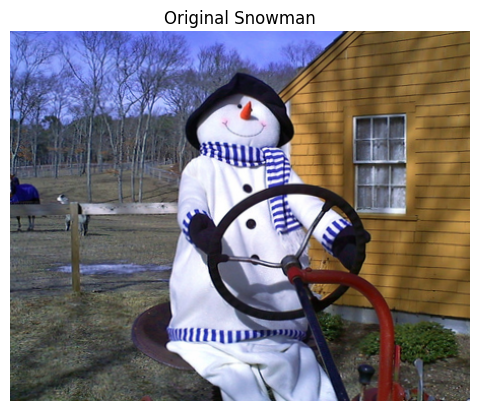

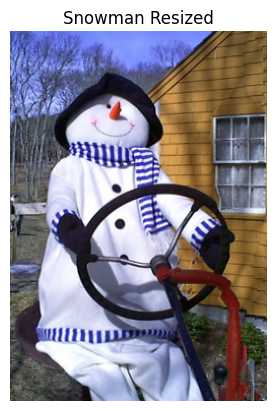

True

In [8]:
# Process images
snowman_resized, snowman_energies = seam_carving(snowman, seams_number, snowman_dmap, snowman_smap, visualize, energy_type='combined')

# Save seam energies
with open('seam_energy_log.txt', 'w') as f:
    f.write('Snowman Seam Energies:\n' + '\n'.join(map(str, snowman_energies)) + '\n')


# Visualize results
plt.imshow(cv2.cvtColor(snowman, cv2.COLOR_BGR2RGB))
plt.title('Original Snowman')
plt.axis('off')
plt.show()
plt.imshow(cv2.cvtColor(snowman_resized, cv2.COLOR_BGR2RGB))
plt.title('Snowman Resized')
plt.axis('off')
plt.show()

# Save resized images
cv2.imwrite('Snowman_resized.png', (snowman_resized * 255).astype(np.uint8))

In [9]:
Diana_path = './Diana.png'
Diana_dmap_path = './Diana_DMap.png'
Diana_smap_path = './Diana_SMap.png'

Diana = cv2.imread(Diana_path).astype(np.float32) / 255.0
Diana_dmap = cv2.imread(Diana_dmap_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
Diana_smap = cv2.imread(Diana_smap_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0

seams_number = 200
visualize = True

Processing seam 1/200...
Processing seam 2/200...
Processing seam 3/200...
Processing seam 4/200...
Processing seam 5/200...
Processing seam 6/200...
Processing seam 7/200...
Processing seam 8/200...
Processing seam 9/200...
Processing seam 10/200...
Processing seam 11/200...
Processing seam 12/200...
Processing seam 13/200...
Processing seam 14/200...
Processing seam 15/200...
Processing seam 16/200...
Processing seam 17/200...
Processing seam 18/200...
Processing seam 19/200...
Processing seam 20/200...
Processing seam 21/200...
Processing seam 22/200...
Processing seam 23/200...
Processing seam 24/200...
Processing seam 25/200...
Processing seam 26/200...
Processing seam 27/200...
Processing seam 28/200...
Processing seam 29/200...
Processing seam 30/200...
Processing seam 31/200...
Processing seam 32/200...
Processing seam 33/200...
Processing seam 34/200...
Processing seam 35/200...
Processing seam 36/200...
Processing seam 37/200...
Processing seam 38/200...
Processing seam 39/20

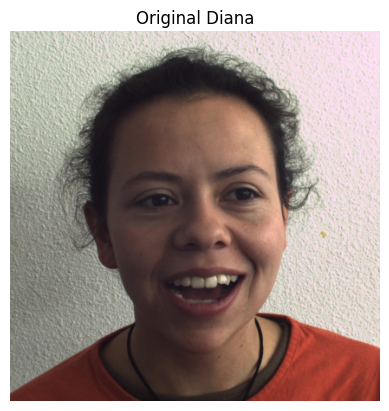

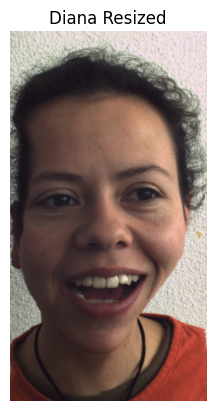

True

In [10]:
# Process images
Diana_resized, Diana_energies = seam_carving(Diana, seams_number, Diana_dmap, Diana_smap, visualize, energy_type='combined')

# Save seam energies
with open('seam_energy_log.txt', 'w') as f:
    f.write('Diana Seam Energies:\n' + '\n'.join(map(str, Diana_energies)) + '\n')

# Visualize results
plt.imshow(cv2.cvtColor(Diana, cv2.COLOR_BGR2RGB))
plt.title('Original Diana')
plt.axis('off')
plt.show()
plt.imshow(cv2.cvtColor(Diana_resized, cv2.COLOR_BGR2RGB))
plt.title('Diana Resized')
plt.axis('off')
plt.show()

# Save resized images
cv2.imwrite('Diana_resized.png', (Diana_resized * 255).astype(np.uint8))